Hi all! This is the updated code for DBA5101 Group Project 1

In this ipynb file, models will be unified to the version we discussed on Sept 16.

Also, evidence for further elaborations from Naive models will be offered in this file. Feel free to check!

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.iv import IV2SLS

In [12]:
import seaborn as sns

In [2]:
# Import source data
# Note: Please change the location when running this code on your own devices
df = pd.read_csv("D:/Academic/25fall/DBA5101 Analytics in Managerial Economics/Group Project/Data-GP1.csv")

Data Cleansing and Feature Generation

In [3]:
# Clean date to standardized date format in pandas
df["parsed_Dept_Date"] = pd.to_datetime(df["Dept_Date"], format = "%m/%d/%y")
df["parsed_Purchase_Date"] = pd.to_datetime(df["Purchase_Date"],format = "%m/%d/%y")

# Calculate lead time = parsed_Dept_Date - parsed_Purchase_Date
df["Lead_Time"] = (df["parsed_Dept_Date"] - df["parsed_Purchase_Date"]).dt.days

# Calculate if the departure date is weekend
df["is_weekend"] = (df["parsed_Dept_Date"].dt.weekday >= 5).astype(int)

# Calculate if the departure date is in the X season (nth quarter) of the year
# i.e. Jan-Mar as "Spring" (1st quarter), Apr-Jun as "Summer" (2nd quarter).
df["quarter"] = df['parsed_Dept_Date'].dt.quarter
df = pd.get_dummies(
    df, columns = ["quarter"], prefix = "is_quarter")
# Avoid full rank when take all quarters as instruments/controls
df.drop(["is_quarter_4"], axis = 1, inplace = True)

# Calculate if the departure date is in a particular month
df["month"] = df['parsed_Dept_Date'].dt.month
df = pd.get_dummies(
    df, columns = ["month"], prefix = "is_month")
# Avoid full rank when take all months as instruments/controls
df.drop(["is_month_12"], axis = 1, inplace = True)

# Transfer column title "num_seats_total" as "demand"
df = df.rename(columns={"num_seats_total": "demand"})

# Calculate log_demand, log_mean_net_ticket_price as we would like to test the price elasticity of demand
df["log_demand"] = np.log(df["demand"])
df["log_mean_net_ticket_price"] = np.log(df["mean_net_ticket_price"])

# Calculate the Lead_Time^2 term because we discovered potential relationship between demand and Lead_Time^2
df["Lead_Time_square"] = df["Lead_Time"] ** 2

# Calculate if the customer is a prime (VIP) customer or not
df = pd.get_dummies(
    df, columns = ["Customer_Cat"], prefix = "is_Customer")
# Avoid full rank when taking Customer_A and Customer_B simultaneously
df.drop(["is_Customer_B"], axis = 1, inplace = True)

# Calculate if the ticket belongs to a specific train (Train Number_A to Train Number_O)
df = pd.get_dummies(
    df, columns = ["Train_Number_All"], prefix = "Train_Number")
# Avoid full rank when take all Train_Number as instruments/controls
df.drop(["Train_Number_O"], axis = 1, inplace = True)


Descriptive statistics and Histograms of important features

In [4]:
# Descriptive Statistics
variable_to_describe = ["demand", "log_demand", "mean_net_ticket_price", "log_mean_net_ticket_price",
                        "Lead_Time", "Lead_Time_square"]
df[variable_to_describe].describe()

,demand,log_demand,mean_net_ticket_price,log_mean_net_ticket_price,Lead_Time,Lead_Time_square
count,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000,209697.000000
mean,2.383019,0.618505,230.116900,5.250089,63.264596,8233.990138
std,2.083324,0.661471,147.024784,0.608971,65.050759,15610.446278
min,1.000000,0.000000,1.278969,0.246054,0.000000,0.000000
25%,1.000000,0.000000,108.870193,4.690156,15.000000,225.000000
50%,2.000000,0.693147,186.282199,5.227263,39.000000,1521.000000
75%,3.000000,1.098612,350.409481,5.859102,91.000000,8281.000000
max,66.000000,4.189655,7855.766106,8.969003,364.000000,132496.000000


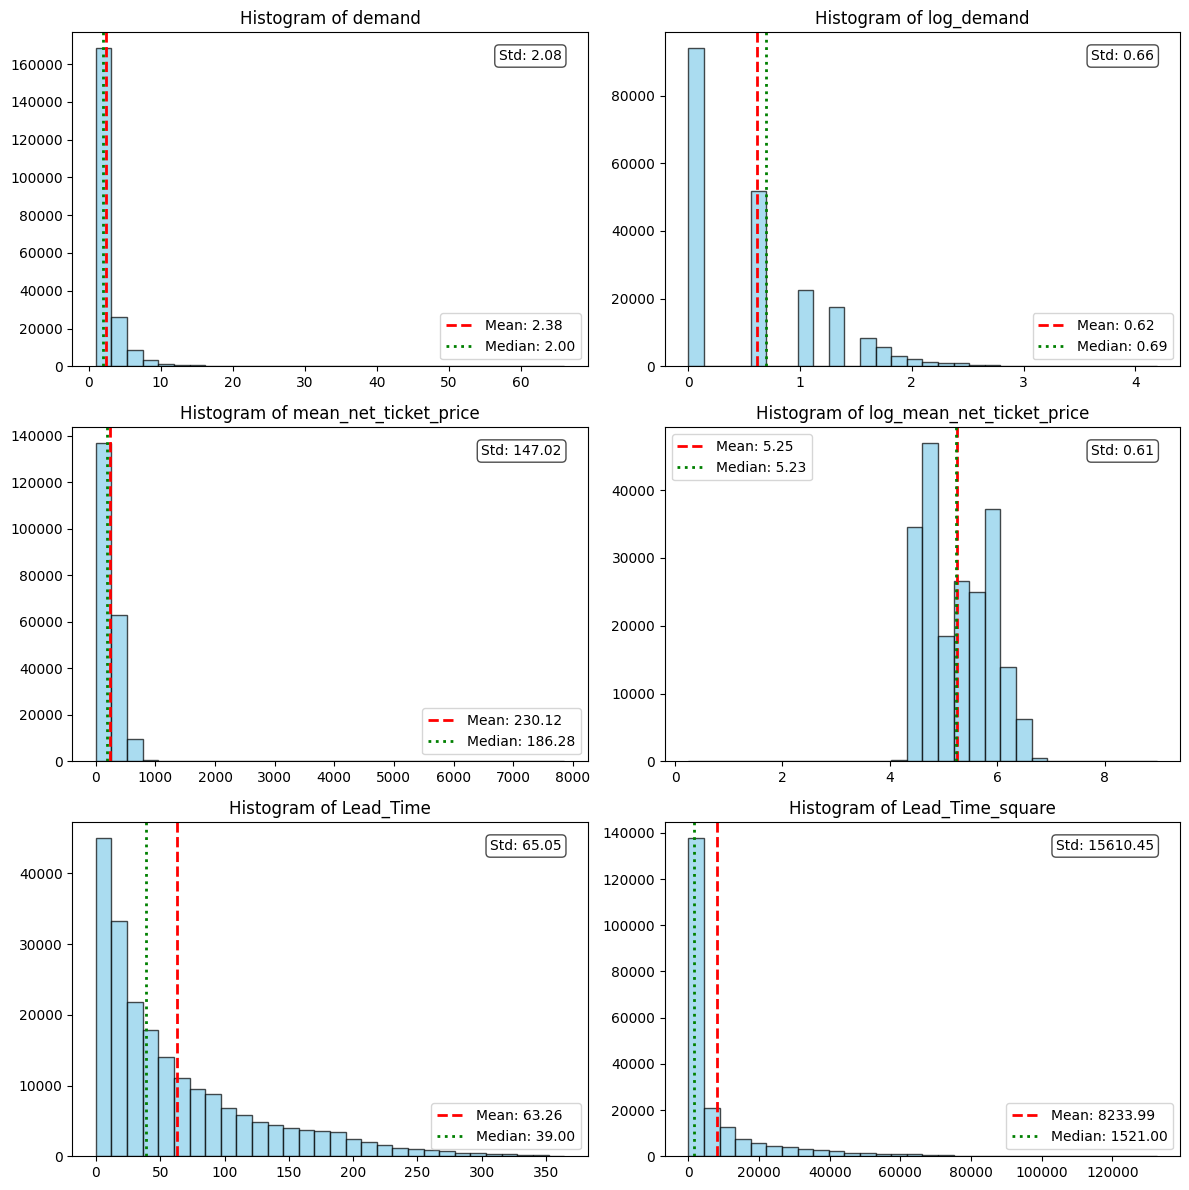

In [5]:
# Histograms of 6 key variables

# Create 3 rows × 2 cols subplot grid
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # make it 1D for easy iteration

for i, var in enumerate(variable_to_describe):
    ax = axes[i]
    data = df[var].dropna()  # drop NaNs if any

    # Plot histogram
    ax.hist(data, bins=30, color="skyblue", edgecolor="black", alpha=0.7)

    # Calculate key stats
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()

    # Add vertical lines for mean & median
    ax.axvline(mean_val, color="red", linestyle="dashed", linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color="green", linestyle="dotted", linewidth=2, label=f"Median: {median_val:.2f}")

    # Add title
    ax.set_title(f"Histogram of {var}", fontsize=12)

    # Show stats inside plot
    textstr = f"Std: {std_val:.2f}"
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
            fontsize=10, va='top', ha='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


Histograms display demand, ticket price and lead time are all positively skewed.

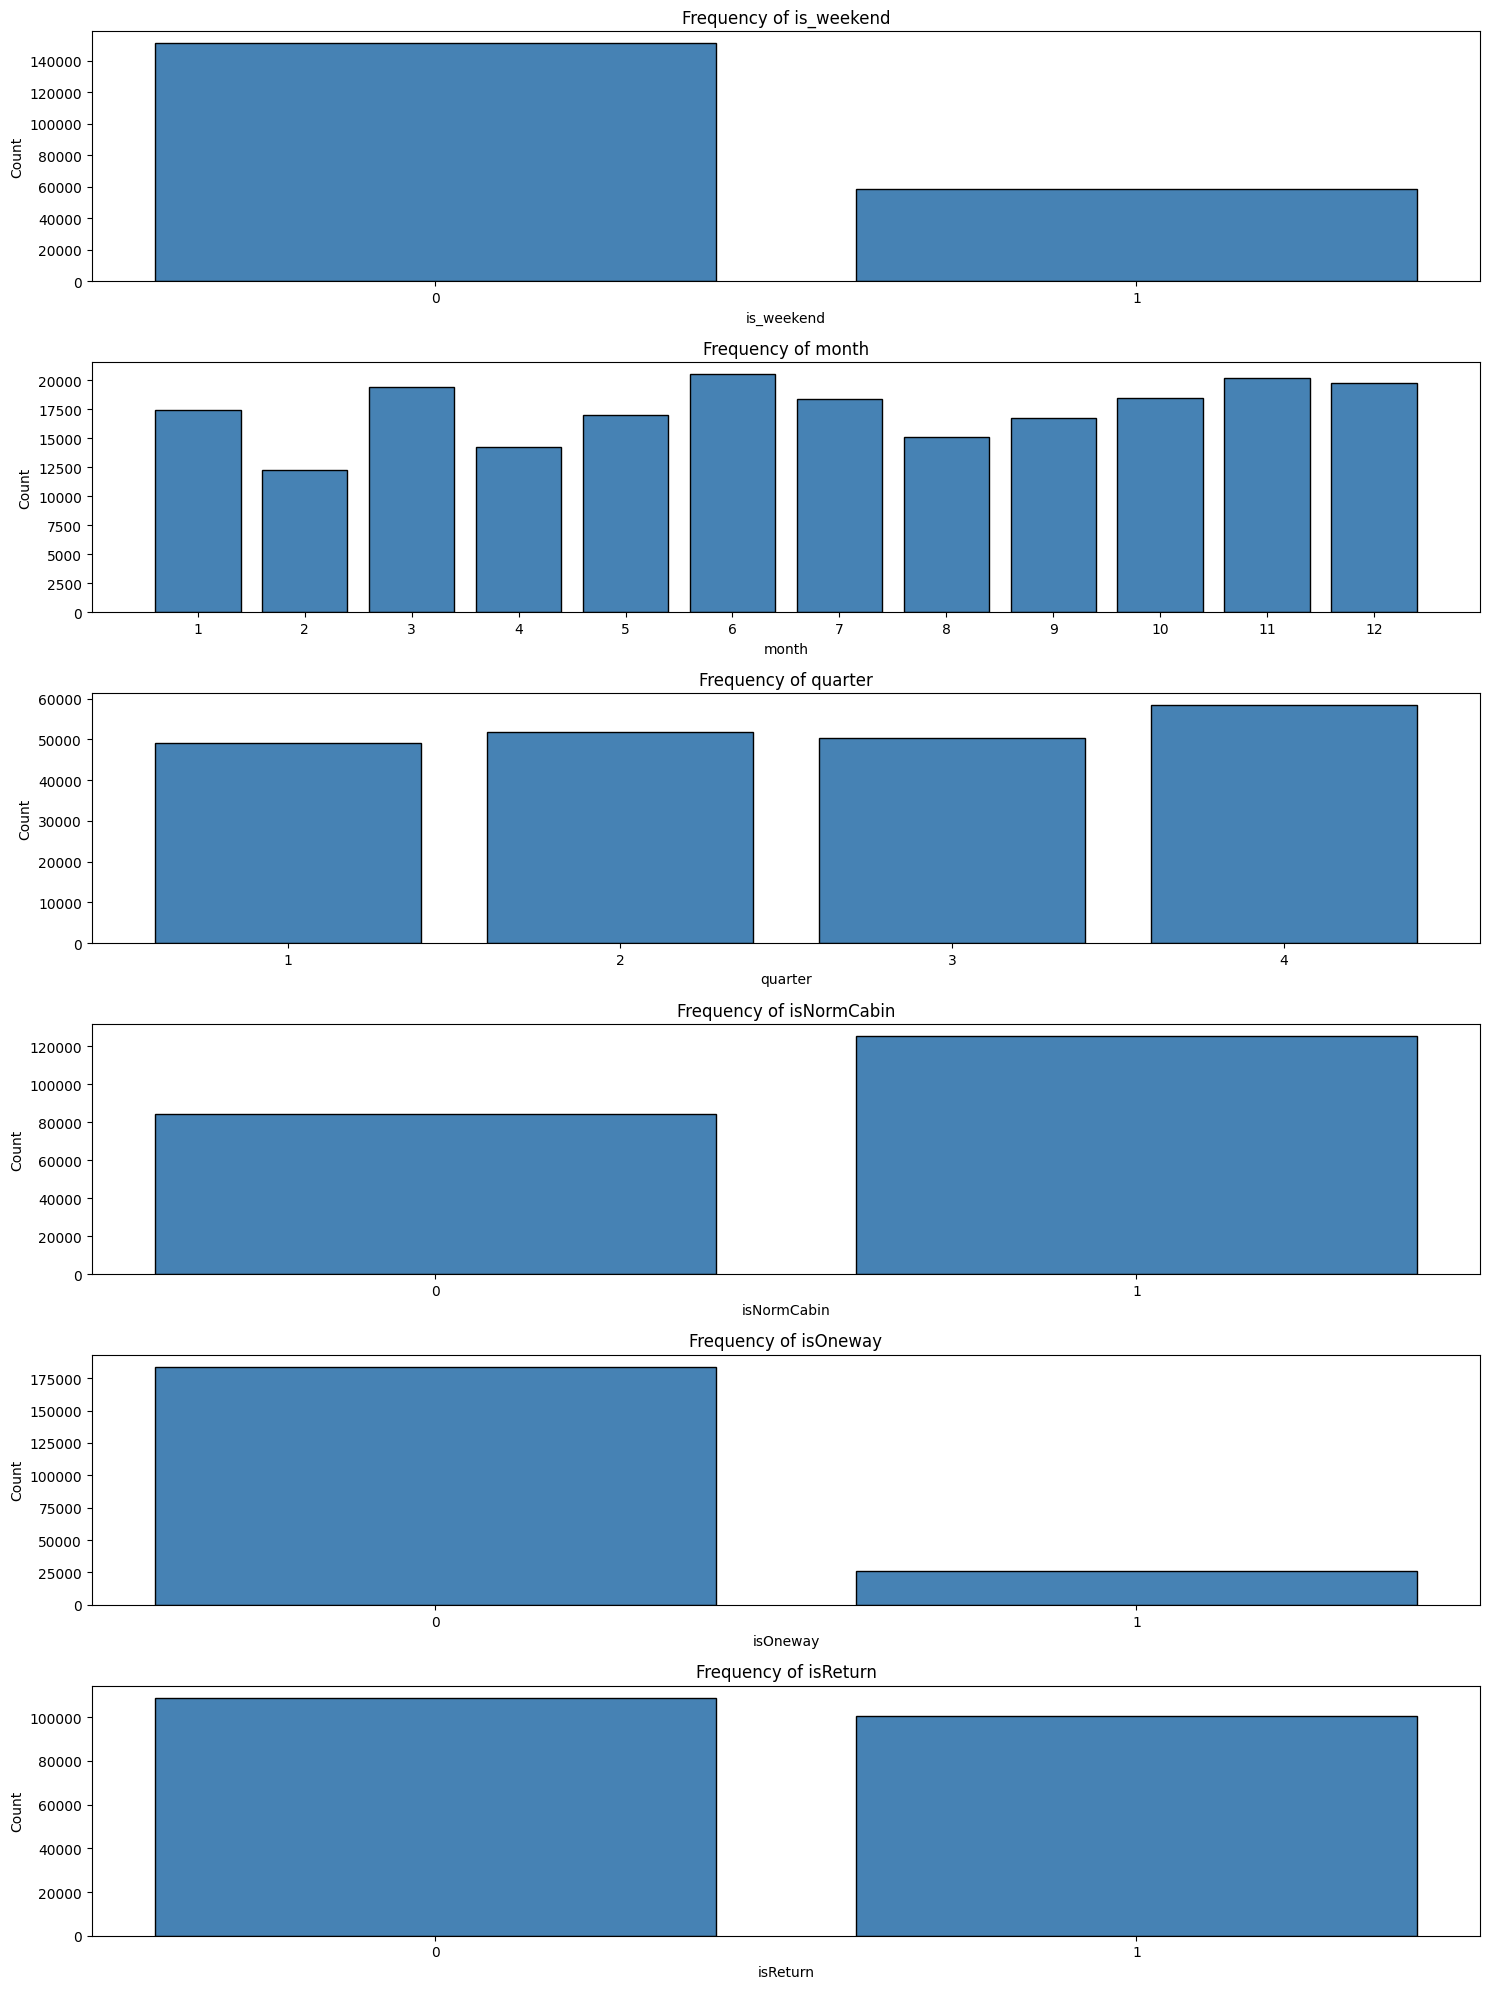

In [9]:
# Recover all category variables deleted but pd.getdummies
df["month"] = df['parsed_Dept_Date'].dt.month
df["quarter"] = df['parsed_Dept_Date'].dt.quarter

# Categorical variables to plot
cat_vars = ["is_weekend", "month", "quarter",
            "isNormCabin", "isOneway", "isReturn"]

fig, axes = plt.subplots(len(cat_vars), 1, figsize=(15, 20))  # 6 rows × 1 col

for i, var in enumerate(cat_vars):
    ax = axes[i]
    counts = df[var].value_counts().sort_index()  # get frequency

    # Bar plot
    ax.bar(counts.index.astype(str), counts.values, color="steelblue", edgecolor="black")

    # Titles & labels
    ax.set_title(f"Frequency of {var}", fontsize=12)
    ax.set_ylabel("Count")
    ax.set_xlabel(var)


plt.tight_layout()
plt.show()

In [11]:
# Scatter plots to discover bivariate relations

import seaborn as sns

# Variable pairs to check
pairs = [
    ("demand", "mean_net_ticket_price"),
    ("log_demand", "mean_net_ticket_price"),
    ("log_demand", "log_mean_net_ticket_price"),
    ("demand", "Lead_Time"),
    ("demand", "Lead_Time_square"),
    ("log_demand", "Lead_Time"),
    ("log_demand", "Lead_Time_square")
]

# Set up plot grid
fig, axes = plt.subplots(len(pairs), 1, figsize=(8, 25))  # one per row

for i, (y_var, x_var) in enumerate(pairs):
    ax = axes[i]

    # Scatter plot
    sns.scatterplot(data=df, x=x_var, y=y_var, alpha=0.5, ax=ax, edgecolor=None)

    # Add linear regression line
    sns.regplot(data=df, x=x_var, y=y_var, scatter=False,
                ax=ax, color="red", label="Linear fit")

    # Add quadratic regression line
    sns.regplot(data=df, x=x_var, y=y_var, scatter=False,
                ax=ax, color="green", label="Quadratic fit", order=2)

    # Titles & legend
    ax.set_title(f"{y_var} ~ {x_var}", fontsize=12)
    ax.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000278A0A6F740> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

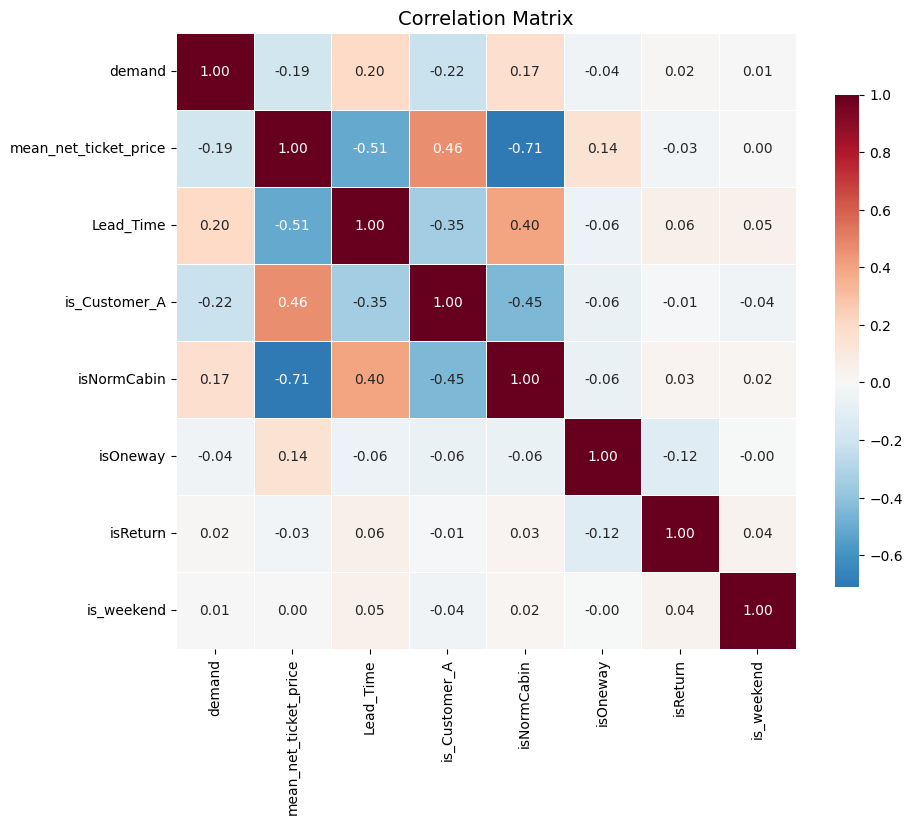

In [14]:
# Correlation matrices

# Variables of interest, Set 1
vars_to_corr = ["demand", "mean_net_ticket_price", "Lead_Time",
                "is_Customer_A", "isNormCabin", "isOneway",
                "isReturn", "is_weekend"]

# Compute correlation matrix
corr = df[vars_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix", fontsize=14)
plt.show()


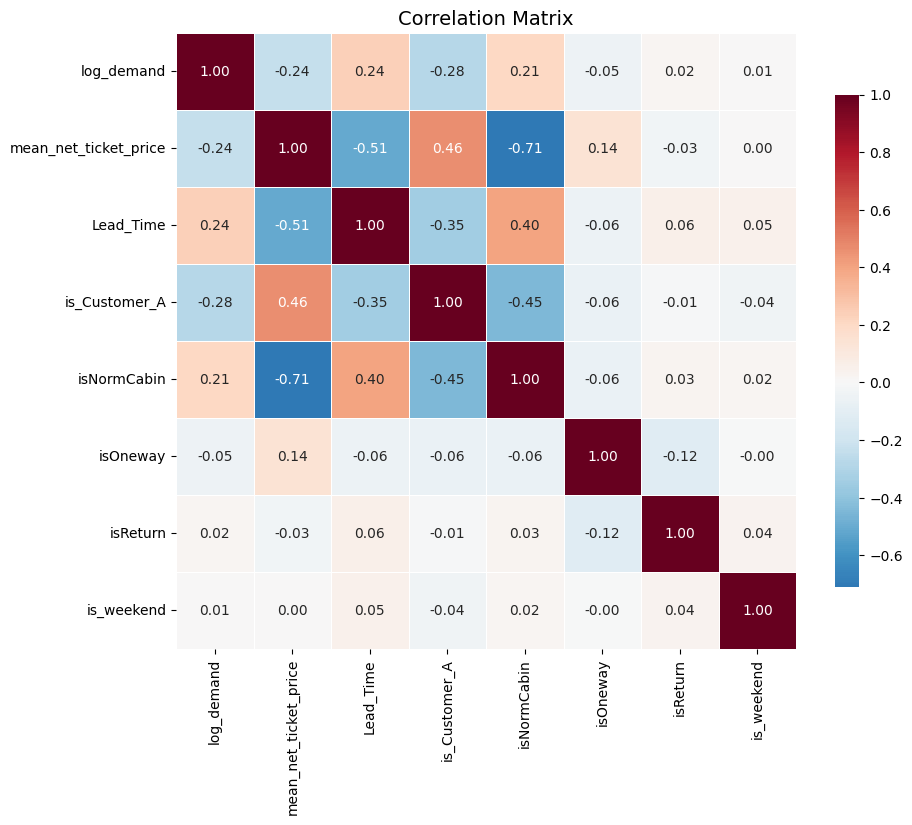

In [15]:
# Variables of interest, Set 2
# log_linear model
vars_to_corr = ["log_demand", "mean_net_ticket_price", "Lead_Time",
                "is_Customer_A", "isNormCabin", "isOneway",
                "isReturn", "is_weekend"]

# Compute correlation matrix
corr = df[vars_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix", fontsize=14)
plt.show()

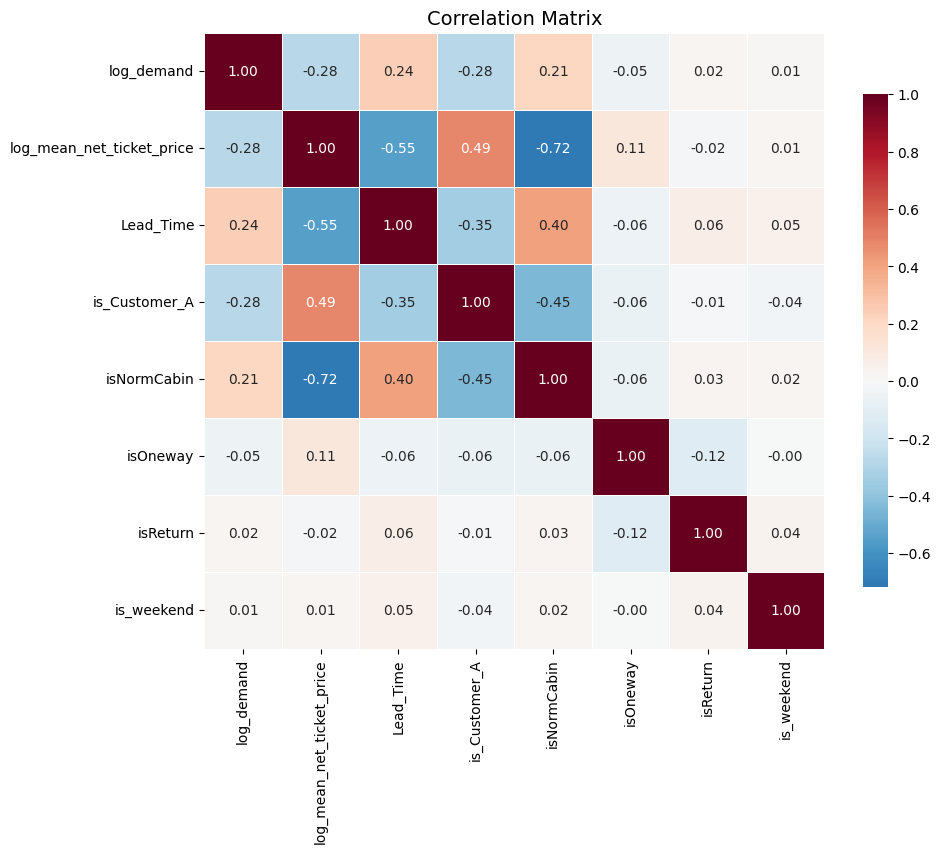

In [16]:
# Variables of interest, Set 3
# log_log model
vars_to_corr = ["log_demand", "log_mean_net_ticket_price", "Lead_Time",
                "is_Customer_A", "isNormCabin", "isOneway",
                "isReturn", "is_weekend"]

# Compute correlation matrix
corr = df[vars_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix", fontsize=14)
plt.show()

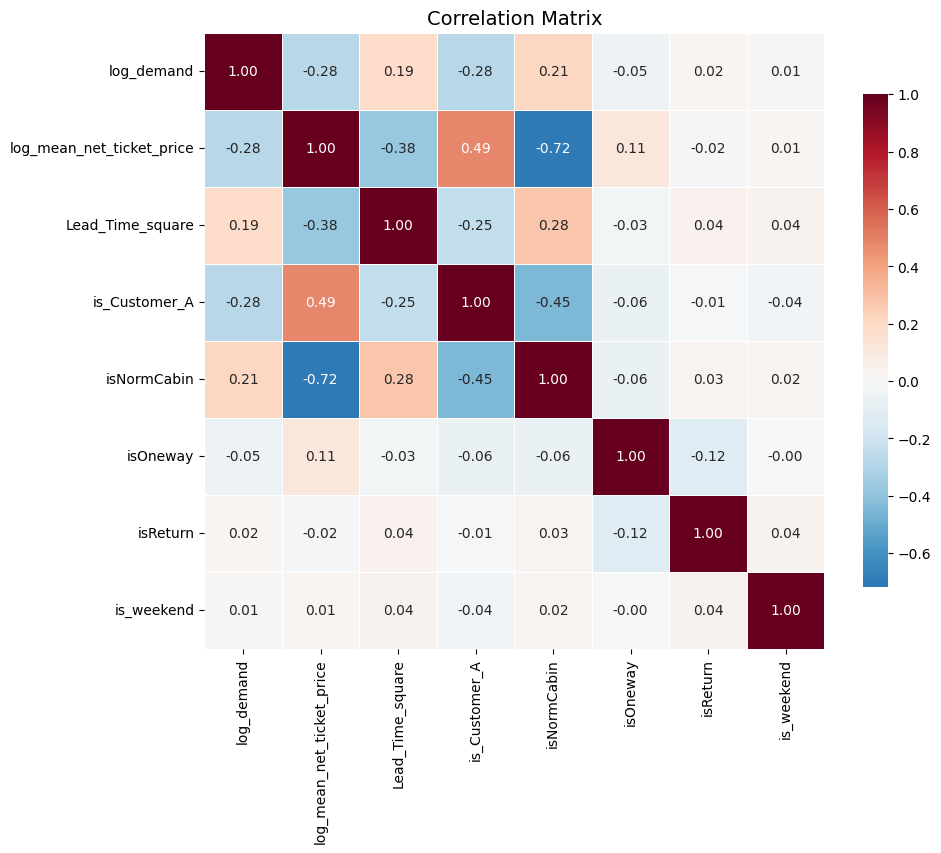

In [17]:
# Variables of interest, Set 3
# log_log model, with Lead_Time transformed into a quadratic term
vars_to_corr = ["log_demand", "log_mean_net_ticket_price", "Lead_Time_square",
                "is_Customer_A", "isNormCabin", "isOneway",
                "isReturn", "is_weekend"]

# Compute correlation matrix
corr = df[vars_to_corr].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix", fontsize=14)
plt.show()

Basic OLS models: compare linear, log-linear and log-log models

In [20]:
# Linear model

# Start with a basic OLS model
# demand ~ 1 + price + Lead_Time + departure_is_weekend  + isNormCabin

y_1_1 = df["demand"]
x_1_1 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time","is_weekend","isNormCabin","is_Customer_A"]].astype(float))

model_1_1 = sm.OLS(y_1_1,x_1_1).fit()
model_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3171.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:44:02   Log-Likelihood:            -4.4381e+05
No. Observations:              209697   AIC:                         8.876e+05
Df Residuals:                  209691   BIC:                         8.877e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.4313      0.019    128.939      0.000       2.394       2.468
mean_net_ticket_price    -0.0007    4.6e-05    -15.511      0.000      -0.001      -0.001
Lead_Time                 0.0038   7.94e-05     48.221      0.000       0.004       0.004
is_weekend               -0.0188      0.010     -1.920      0.055      -0.038       0.000
isNormCabin               0.0779      0.013      6.006      0.000       0.052       0.103
is_Customer_A            -0.7440      0.012    -61.177      0.000      -0.768      -0.720
==============================================================================
Omnibus:                   167957.282   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8799940.863
Skew:                           3.470   Prob(JB):                         0.00
Kurtosis:                      33.968   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

NOTE: Here the multicollinearity might be caused by price ~ isNormCabin (0.71 correlation)
So I just remove isNormCabin to test if collinearity still exists.

In [23]:
# Remove isNormCabin
y_1_2 = df["demand"]
x_1_2 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time","is_weekend","is_Customer_A"]].astype(float))

model_1_2 = sm.OLS(y_1_2,x_1_2).fit()
model_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3955.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:55:52   Log-Likelihood:            -4.4383e+05
No. Observations:              209697   AIC:                         8.877e+05
Df Residuals:                  209692   BIC:                         8.877e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.5168      0.012    203.469      0.000       2.493       2.541
mean_net_ticket_price    -0.0009   3.71e-05    -23.616      0.000      -0.001      -0.001
Lead_Time                 0.0038   7.94e-05     48.513      0.000       0.004       0.004
is_weekend               -0.0176      0.010     -1.792      0.073      -0.037       0.002
is_Customer_A            -0.7571      0.012    -63.274      0.000      -0.781      -0.734
==============================================================================
Omnibus:                   167969.825   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8800734.193
Skew:                           3.470   Prob(JB):                         0.00
Kurtosis:                      33.969   Cond. No.                         801.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

See, multicollinearity disappears! Removing isNormCabin is a right decision!

In [24]:
# continue on linear model
# add departure season / departure month in this model and make comparisons on R^2
# Although we do not care about fitting accuracy. What matters only is interpretability

# One possible worry is too many months together can cause multicollinearity issue

# demand ~ 1 + price + Lead_Time + departure_is_weekend + departure_season (3 variables) + Customer_Cat

y_1_3 = df["demand"]
x_1_3 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time","is_weekend","is_Customer_A",
                            "is_quarter_1", "is_quarter_2", "is_quarter_3"]].astype(float))

model_1_3 = sm.OLS(y_1_3,x_1_3).fit()
model_1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2352.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:57:13   Log-Likelihood:            -4.4353e+05
No. Observations:              209697   AIC:                         8.871e+05
Df Residuals:                  209689   BIC:                         8.872e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.6708      0.015    173.324      0.000       2.641       2.701
mean_net_ticket_price    -0.0010   3.73e-05    -26.023      0.000      -0.001      -0.001
Lead_Time                 0.0035   8.14e-05     43.436      0.000       0.003       0.004
is_weekend               -0.0159      0.010     -1.622      0.105      -0.035       0.003
is_Customer_A            -0.7473      0.012    -62.506      0.000      -0.771      -0.724
is_quarter_1             -0.1320      0.012    -10.675      0.000      -0.156      -0.108
is_quarter_2             -0.0589      0.012     -4.777      0.000      -0.083      -0.035
is_quarter_3             -0.2893      0.012    -23.182      0.000      -0.314      -0.265
==============================================================================
Omnibus:                   168099.188   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8850331.649
Skew:                           3.473   Prob(JB):                         0.00
Kurtosis:                      34.059   Cond. No.                     1.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

is_Quarter_x bring about multicollinearity while fail to boost R^2 a lot

In [25]:
# demand ~ 1 + price + Lead_Time + departure_is_weekend + departure_month (11 variables) + is_Prime_Customer

y_1_4 = df["demand"]
x_1_4 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time","is_weekend","is_Customer_A",
                            "is_month_1", "is_month_2", "is_month_3", "is_month_4","is_month_5",
                            "is_month_6","is_month_7","is_month_8","is_month_9","is_month_10",
                            "is_month_11",]].astype(float))

model_1_4 = sm.OLS(y_1_4,x_1_4).fit()
model_1_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1225.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:02:47   Log-Likelihood:            -4.4265e+05
No. Observations:              209697   AIC:                         8.853e+05
Df Residuals:                  209681   BIC:                         8.855e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.1348      0.021    149.302      0.000       3.094       3.176
mean_net_ticket_price    -0.0012   3.78e-05    -31.224      0.000      -0.001      -0.001
Lead_Time                 0.0030   8.28e-05     36.744      0.000       0.003       0.003
is_weekend               -0.0292      0.010     -2.989      0.003      -0.048      -0.010
is_Customer_A            -0.7236      0.012    -60.584      0.000      -0.747      -0.700
is_month_1               -0.6247      0.021    -29.674      0.000      -0.666      -0.583
is_month_2               -0.6784      0.023    -29.247      0.000      -0.724      -0.633
is_month_3               -0.3208      0.021    -15.520      0.000      -0.361      -0.280
is_month_4               -0.5219      0.022    -23.312      0.000      -0.566      -0.478
is_month_5               -0.6050      0.022    -28.085      0.000      -0.647      -0.563
is_month_6               -0.2718      0.020    -13.305      0.000      -0.312      -0.232
is_month_7               -0.7050      0.021    -33.143      0.000      -0.747      -0.663
is_month_8               -0.6350      0.022    -28.875      0.000      -0.678      -0.592
is_month_9               -0.7027      0.022    -32.601      0.000      -0.745      -0.660
is_month_10              -0.6995      0.021    -33.465      0.000      -0.740      -0.659
is_month_11              -0.4491      0.020    -22.210      0.000      -0.489      -0.409
==============================================================================
Omnibus:                   168453.399   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9094982.711
Skew:                           3.475   Prob(JB):                         0.00
Kurtosis:                      34.506   Cond. No.                     3.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Still this case! is_month_x bring about multicollinearity while not boost R^2 a lot!

In [27]:
# Test if Lead_Time or Lead_Time^2 is better

# demand ~ 1 + price + Lead_Time^2 + departure_is_weekend + is_Prime_Customer

y_1_5 = df["demand"]
x_1_5 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time_square","is_weekend","is_Customer_A"]].astype(float))

model_1_5 = sm.OLS(y_1_5,x_1_5).fit()
model_1_5.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3786.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:07:00   Log-Likelihood:            -4.4415e+05
No. Observations:              209697   AIC:                         8.883e+05
Df Residuals:                  209692   BIC:                         8.884e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.7468      0.010    277.584      0.000       2.727       2.766
mean_net_ticket_price    -0.0012    3.5e-05    -35.689      0.000      -0.001      -0.001
Lead_Time_square       1.251e-05   3.02e-07     41.466      0.000    1.19e-05    1.31e-05
is_weekend               -0.0071      0.010     -0.726      0.468      -0.026       0.012
is_Customer_A            -0.7878      0.012    -66.052      0.000      -0.811      -0.764
==============================================================================
Omnibus:                   167857.113   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8750598.911
Skew:                           3.468   Prob(JB):                         0.00
Kurtosis:                      33.877   Cond. No.                     4.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It performs worse than linear term

Now we would like to move forward to log linear model to see how much percent of demand would change due to one unit of price chance.

In [28]:
# log-linear model

# Start from the basic model
# log(demand) ~ 1 + price + Lead_Time + departure_is_weekend + is_Prime_Customer

y_2_1 = df["demand"]
x_2_1 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time","is_weekend","is_Customer_A"]].astype(float))

model_2_1 = sm.OLS(y_2_1,x_2_1).fit()
model_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3955.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:12:09   Log-Likelihood:            -4.4383e+05
No. Observations:              209697   AIC:                         8.877e+05
Df Residuals:                  209692   BIC:                         8.877e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.5168      0.012    203.469      0.000       2.493       2.541
mean_net_ticket_price    -0.0009   3.71e-05    -23.616      0.000      -0.001      -0.001
Lead_Time                 0.0038   7.94e-05     48.513      0.000       0.004       0.004
is_weekend               -0.0176      0.010     -1.792      0.073      -0.037       0.002
is_Customer_A            -0.7571      0.012    -63.274      0.000      -0.781      -0.734
==============================================================================
Omnibus:                   167969.825   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8800734.193
Skew:                           3.470   Prob(JB):                         0.00
Kurtosis:                      33.969   Cond. No.                         801.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# Test if Lead_Time^2 is better?

# log(demand) ~ 1 + price + Lead_Time^2 + departure_is_weekend + is_Prime_Customer

y_2_2 = df["demand"]
x_2_2 = sm.add_constant(df[["mean_net_ticket_price", "Lead_Time_square","is_weekend","is_Customer_A"]].astype(float))

model_2_2 = sm.OLS(y_2_2,x_2_2).fit()
model_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3786.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:14:17   Log-Likelihood:            -4.4415e+05
No. Observations:              209697   AIC:                         8.883e+05
Df Residuals:                  209692   BIC:                         8.884e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.7468      0.010    277.584      0.000       2.727       2.766
mean_net_ticket_price    -0.0012    3.5e-05    -35.689      0.000      -0.001      -0.001
Lead_Time_square       1.251e-05   3.02e-07     41.466      0.000    1.19e-05    1.31e-05
is_weekend               -0.0071      0.010     -0.726      0.468      -0.026       0.012
is_Customer_A            -0.7878      0.012    -66.052      0.000      -0.811      -0.764
==============================================================================
Omnibus:                   167857.113   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8750598.911
Skew:                           3.468   Prob(JB):                         0.00
Kurtosis:                      33.877   Cond. No.                     4.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Lead_Time^2 actually harms interpretability instead of benifits.

Because adding month and quarter categorical variables will lead to multicollinearity, we would not try them here further.

In [30]:
# log-log model

# We also would like to deep dive into the price elasticity of demand.
# log(demand) = 1 + log (mean_net_ticket_price) + Lead_Time + departure_is_weekend + is_Prime_Customer

y_3_1 = df["demand"]
x_3_1 = sm.add_constant(df[["log_mean_net_ticket_price", "Lead_Time","is_weekend","is_Customer_A"]].astype(float))

model_3_1 = sm.OLS(y_3_1,x_3_1).fit()
model_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4228.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:21:03   Log-Likelihood:            -4.4332e+05
No. Observations:              209697   AIC:                         8.867e+05
Df Residuals:                  209692   BIC:                         8.867e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.2768      0.051     84.481      0.000       4.178       4.376
log_mean_net_ticket_price    -0.3693      0.009    -39.714      0.000      -0.388      -0.351
Lead_Time                     0.0031   8.12e-05     38.639      0.000       0.003       0.003
is_weekend                   -0.0024      0.010     -0.244      0.807      -0.022       0.017
is_Customer_A                -0.6761      0.012    -56.072      0.000      -0.700      -0.652
==============================================================================
Omnibus:                   168249.821   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8891185.507
Skew:                           3.476   Prob(JB):                         0.00
Kurtosis:                      34.133   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Potential multicollinearity occurs between Lead_time and log(price). So we would like to try Lead_Time^2 to test if this issue is eliminated.

In [32]:
# Replace Lead_Time with Lead_Time^2

# log(demand) = 1 + log (mean_net_ticket_price) + Lead_Time^2 + departure_is_weekend + is_Prime_Customer

y_3_2 = df["demand"]
x_3_2 = sm.add_constant(df[["log_mean_net_ticket_price", "Lead_Time_square","is_weekend","is_Customer_A"]].astype(float))

model_3_2 = sm.OLS(y_3_2,x_3_2).fit()
model_3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     4153.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:25:58   Log-Likelihood:            -4.4346e+05
No. Observations:              209697   AIC:                         8.869e+05
Df Residuals:                  209692   BIC:                         8.870e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.7862      0.045    105.686      0.000       4.697       4.875
log_mean_net_ticket_price    -0.4450      0.009    -51.476      0.000      -0.462      -0.428
Lead_Time_square            1.06e-05   3.04e-07     34.816      0.000       1e-05    1.12e-05
is_weekend                    0.0073      0.010      0.745      0.456      -0.012       0.026
is_Customer_A                -0.6930      0.012    -57.584      0.000      -0.717      -0.669
==============================================================================
Omnibus:                   168207.181   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8874928.251
Skew:                           3.475   Prob(JB):                         0.00
Kurtosis:                      34.104   Cond. No.                     1.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Multicollinearity still exists. Try further to remove Lead_Time?

In [41]:
y_3_3 = df["demand"]
x_3_3 = sm.add_constant(df[["log_mean_net_ticket_price", "is_weekend", "is_Customer_A"]].astype(float))

model_3_3 = sm.OLS(y_3_3,x_3_3).fit()
model_3_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     5103.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:31:40   Log-Likelihood:            -4.4407e+05
No. Observations:              209697   AIC:                         8.881e+05
Df Residuals:                  209693   BIC:                         8.882e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         5.3602      0.042    126.717      0.000       5.277       5.443
log_mean_net_ticket_price    -0.5371      0.008    -65.079      0.000      -0.553      -0.521
is_weekend                    0.0224      0.010      2.288      0.022       0.003       0.042
is_Customer_A                -0.7254      0.012    -60.288      0.000      -0.749      -0.702
==============================================================================
Omnibus:                   167979.874   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8731381.584
Skew:                           3.473   Prob(JB):                         0.00
Kurtosis:                      33.839   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Seems OK, but R^2 drops down to 0.068.

One step further: 2SLS to tackle endogeneity and omitted variables

Durbin-Wu-Watson Test: check the necessity for 2SLS

In [ ]:
# Durbin-Wu-Watson Test


2SLS model

In [ ]:
# 2SLS for linear model


In [ ]:
# 2SLS for log-linear model
